Bastián Marinkovic

La siguiente solución está basada en el material visto en clase

# Diagrama general

Esta tarea contiene 3 grupos de soluciones con varios algoritmos. Los grupos de soluciones se dividen en sin selección de caracteríscas, seleccionando y realizando PCA.

Las técnicas empleadas en cada grupo van disminuyendo su cantidad dado se fue iterando sobre la solución y se filtró que usar y que no, al momento de definir el siguiente grupo.

A continuación se presenta un diagrama con el flujo general este contiene la información de los grupos de soluciones.

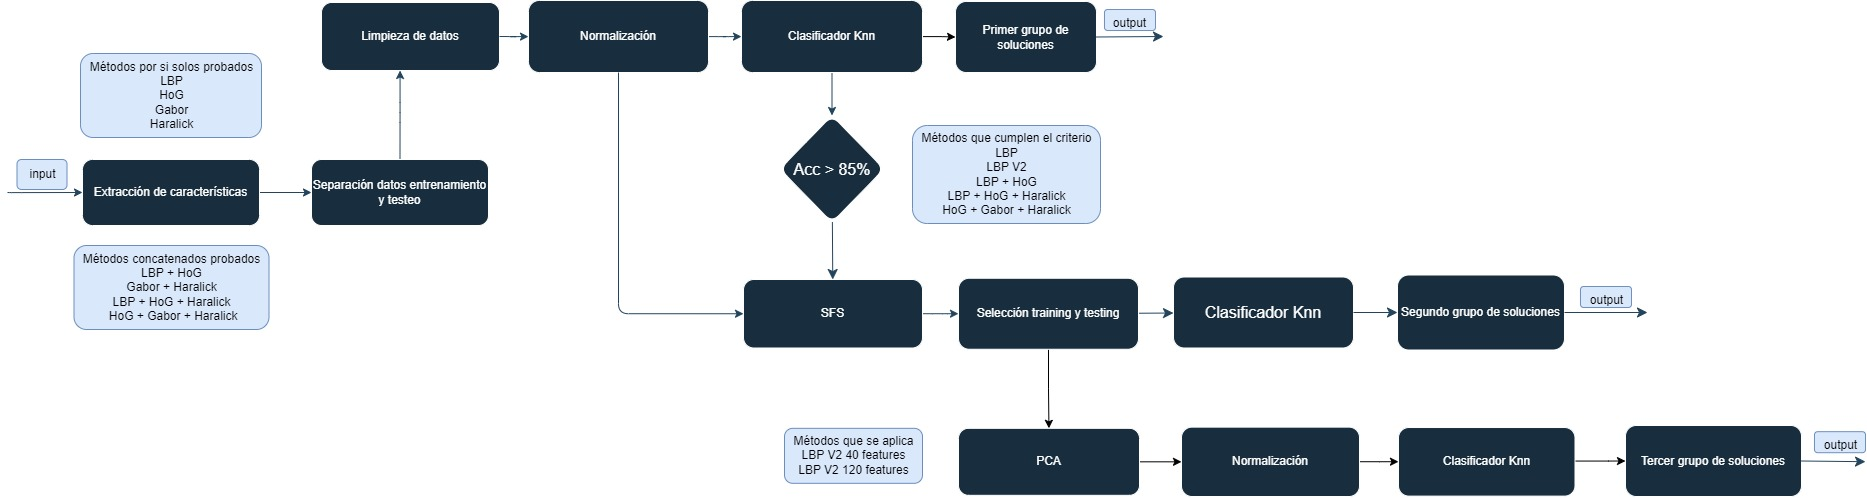

# Set Up

In [1]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 261 (delta 152), reused 177 (delta 74), pack-reused 0
Receiving objects: 100% (261/261), 68.46 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43704 sha256=b2b784496fa8733419123bafb504f9560089d4c221a3837a8f04d0acba05599d
  Stored in directory: /tmp/pip-ephem-wheel-cache-4keolhwh/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


# Librerías

In [2]:
# General
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
from   tqdm.auto import tqdm

# Extraccion/transformación/seleccion de caracteristicas, clasificacion, evaluacion
from   balu3.fx.chr import lbp, haralick, gabor, hog
from   balu3.io.misc import imageload
from   balu3.cl.basics import SplitTrainTest, ClassifierKNN 
from   balu3.ft.trans  import pca
from   balu3.fx.geo    import fourierdes, hugeo, flusser, gupta,basicgeo
from   balu3.fs.sel    import sfs,clean, jfisher, exsearch
from   balu3.ft.norm   import minmax

# Decargar las imágenes

In [3]:
!wget https://www.dropbox.com/s/3slh34iulgc8nir/FWM.zip
!unzip -qq FWM.zip

--2023-05-15 04:45:20--  https://www.dropbox.com/s/3slh34iulgc8nir/FWM.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/3slh34iulgc8nir/FWM.zip [following]
--2023-05-15 04:45:21--  https://www.dropbox.com/s/raw/3slh34iulgc8nir/FWM.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc88c2d0d78e6c59719ac6d18995.dl.dropboxusercontent.com/cd/0/inline/B8GrDSgtc6sNsZ1IJe3cMmHgud5Yi2rxabub-mf0Q9hNTnV-sMILKaZ0rfMviWRf-UP1-ygErow2IoYEAnGl7_dahTQEAcOGsrnbHYo1qHHjdT9iURjYWP6-9vB2KS_EtmVnUgIzltROEHBMS3d_oDv67phN9YDjqSvX0ivU1tVrOw/file# [following]
--2023-05-15 04:45:21--  https://uc88c2d0d78e6c59719ac6d18995.dl.dropboxusercontent.com/cd/0/inline/B8GrDSgtc6sNsZ1IJe3cMmHgud5Yi2rxabub-mf0Q9hNTnV-sMILKaZ0rfMviWRf-UP1-ygErow2IoYEAnGl7_dahTQE

# Extracción de características
Se realiza la extracción de características de las imágenes. Para omitir este paso véase Carga de características.



In [4]:
imprefix = 'FWM/face_'
dig_class = 3
dig_img = 3

Extracción de características variables y sus significados

- Matriz X1 LBP
- Matriz X2 HoG
- Matriz X3 GABOR
- Matriz X4 HARALICK
- Matriz X1V2 LBP con particiones de 2x2
- Matriz X2V2 HoG con particiones de 2x2
- Matriz X4V2 HARALICK para d = 1
- vector y

Esta sección es sobre los nombres de las cantidades de caracteristicas para cada método

- Mlbp NUMERO DE ELEMENTOS DEL VECTOR LBP
- Mhog NUMERO DE ELEMENTOS DEL VECTOR DE HoG
- MlbpV2 NUMERO DE ELEMENTOS DEL VECTOR LBP V2
- MhogV2 NUMERO DE ELEMENTOS DEL VECTOR DE HoG V2
- Mgab NUMERO DE ELEMENTOS DEL VECTOR DE GABOR
- Mhar NUMERO DE ELEMENTOS DEL VECTOR DE HARALICK

In [10]:
K    = 100           # NUMERO DE CLASES
N    = 5             # NUMERO DE IMAGENES POR CLASE

# numero de elementos por vector
Mlbp = 59             
Mhog = 9              
MlbpV2 = 59 * 2 * 2   
MhogV2 = 9 * 2 * 2    
Mgab = 67             
Mhar = 24             

X1  = np.zeros((K*N,Mlbp))      # K*N muestras (filas), y Mlbp características (columnas)
X2  = np.zeros((K*N,Mhog))      # K*N muestras (filas), y Mhog características (columnas)
X3  = np.zeros((K*N,Mgab))      # K*N muestras (filas), y Mgab características (columnas)
X4  = np.zeros((K*N,Mhar))      # K*N muestras (filas), y Mhar características (columnas)

X1V2  = np.zeros((K*N,MlbpV2))  # K*N muestras (filas), y MlbpV2 características (columnas)
X2V2  = np.zeros((K*N,MhogV2))  # K*N muestras (filas), y MhogV2 características (columnas)
X4V2  = np.zeros((K*N,Mhar))    # K*N muestras (filas), y Mhar características (columnas)

y     = np.zeros((K*N),'int')             # ground truth (clasificacion ideal)

t = 0

for j in range(K):                        
  for i in tqdm(range(N)):                
    clase     = j+1
    num_img   = i+1
    img       = 255*imageload(imprefix,clase,dig_class,num_img,dig_img)

    # Extracción de características

    # LBP
    X1[t,:]   = lbp(img, hdiv=1, vdiv=1)
    X1V2[t,:] = lbp(img, hdiv=2, vdiv=2)

    # HoG
    X2[t,:]   = hog(img, orientations=9, pixels_per_cell=(128,128),cells_per_block=(1,1),norm=False)
    X2V2[t,:] = hog(img, orientations=9, pixels_per_cell=(64,64),cells_per_block=(2,2),norm=False)

    # Gabor
    X3[t,:] = gabor(img, rotations=8, dilations=8)

    # Haralick
    X4[t,:]   = haralick(img, distance=3)
    X4V2[t,:] = haralick(img, distance=1)

    y[t] = j # la muestra t pertenece a la clase j
    t = t+1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Combinación de técnicas

In [11]:
X7 = np.concatenate((X1,X2), axis=1)              # CONCATENACIÓN DE LBP, HoG
X8 = np.concatenate((X1,X2,X4), axis=1)           # CONCATENACIÓN DE LBP, HoG Y Haralick
X9 = np.concatenate((X3,X4), axis=1)              # CONCATENACIÓN DE GABOR, Y Haralick
X10 = np.concatenate((X2V2,X3,X4), axis=1)        # CONCATENACIÓN DE HoG version 2, Gabor Y Haralick
X11 = np.concatenate((X3,X4V2), axis=1)           # CONCATENACIÓN DE GABOR, Y Haralick version 2

In [12]:
value_list = [X1, X1V2, X2, X2V2, X3, X4, X4V2, X7, X8, X9, X10, X11, y]

# Guardar extracción de características

Las siguientes funciones son utilizadas para guardar las características generadas en un archivo .zip, para luego almacenarlo en dropbox. La carga en dropbox es de forma manual, para esto se descarga el archivo y se guarda en la plataforma

In [13]:
def save_feature_extraction(name, value):
  np.savetxt(name, value)

def save_feature_as_zip(name_list, value_list, folder_name):
  import zipfile

  # Se crea un archivo .zip
  with zipfile.ZipFile(f'{folder_name}.zip', mode='w') as zip:
      # Se agregan los archivos de texto al archivo .zip
      idx = 0
      for i in name_list:
        save_feature_extraction(i, value_list[idx])
        zip.write(i)
        idx += 1


In [14]:
name_list = [f'X{i}' for i in range(1,14)]
save_feature_as_zip(name_list,value_list,'features')

# Carga de características

El link donde se encuentra el zip de las caracteríscas es el siguiente
https://www.dropbox.com/s/t62wp78avunnewa/features.zip?dl=0 este se descarga y se asignan sus valores a las variables

In [4]:
!wget https://www.dropbox.com/s/t62wp78avunnewa/features.zip
!unzip -qq features.zip

--2023-05-15 04:45:23--  https://www.dropbox.com/s/t62wp78avunnewa/features.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/t62wp78avunnewa/features.zip [following]
--2023-05-15 04:45:23--  https://www.dropbox.com/s/raw/t62wp78avunnewa/features.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc76938170e2c5f075e090a07101.dl.dropboxusercontent.com/cd/0/inline/B8HTbnax2eRZwYayXQ6NN-rNBBkdUyTZOty-wkK8OnaEZn5cAM599l2hhjg1J1T16rzuqFERyrFQr2-jc82nCjGL7yguI7EtwS4z6IOvqorpXeru23GKnhYbF7JaB7iCpLURZaLNHZ1DRotLMdWRrTjjWjhXVyQd8rAZ8vfTTnCBHw/file# [following]
--2023-05-15 04:45:24--  https://uc76938170e2c5f075e090a07101.dl.dropboxusercontent.com/cd/0/inline/B8HTbnax2eRZwYayXQ6NN-rNBBkdUyTZOty-wkK8OnaEZn5cAM599l2hhjg1J1T16rzuqFERyrFQr

In [5]:
value_list = [0] * 13

In [6]:
for i in range(1, 14):
  value_list[i - 1] = np.loadtxt(f'X{i}')

#X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11 = value_list
X1, X1V2, X2, X2V2, X3, X4, X4V2, X7, X8, X9, X10, X11, y = value_list
y = y.astype(int)

# Separación datos en test y entrenamiento

Se crea una función que realice la separación de los datos de entrenamineto con los de testing, además esta función limpia y normaliza los datos

In [7]:
def splitNormalizeAndCleanData(X, y, number_training_img):
  Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,number_training_img)

  sclean = clean(Xtrain)               
  Xtrain_clean = Xtrain[:,sclean] 
  Xtest_clean  = Xtest[:,sclean]
  
  Xtrain_norm, a, b = minmax(Xtrain_clean)
  Xtest_norm        = Xtest_clean * a + b

  return Xtrain_norm, ytrain, Xtest_norm, ytest

Aplicación de la función

In [8]:
XtrainLBP,ytrainLBP,XtestLBP,ytestLBP = splitNormalizeAndCleanData(X1, y, 4)
XtrainHog,ytrainHog,XtestHog,ytestHog = splitNormalizeAndCleanData(X2, y, 4)
XtrainGAB,ytrainGAB,XtestGAB,ytestGAB = splitNormalizeAndCleanData(X3, y, 4)
XtrainHAR,ytrainHAR,XtestHAR,ytestHAR = splitNormalizeAndCleanData(X4, y, 4)

XtrainLBPV2,ytrainLBPV2,XtestLBPV2,ytestLBPV2 = splitNormalizeAndCleanData(X1V2, y, 4)
XtrainHogV2,ytrainHogV2,XtestHogV2,ytestHogV2 = splitNormalizeAndCleanData(X2V2, y, 4)
XtrainHARV2,ytrainHARV2,XtestHARV2,ytestHARV2 = splitNormalizeAndCleanData(X4V2, y, 4)

# concatenación de metodos, para abreviar se mencioanan como C1, C2, ... por 
# concatenación 1, 2, ...
XtrainC1,ytrainC1,XtestC1,ytestC1 = splitNormalizeAndCleanData(X7, y, 4)
XtrainC2,ytrainC2,XtestC2,ytestC2 = splitNormalizeAndCleanData(X8, y, 4)
XtrainC3,ytrainC3,XtestC3,ytestC3 = splitNormalizeAndCleanData(X9, y, 4)
XtrainC4,ytrainC4,XtestC4,ytestC4 = splitNormalizeAndCleanData(X10, y, 4)
XtrainC5,ytrainC5,XtestC5,ytestC5 = splitNormalizeAndCleanData(X11, y, 4)

# se pruban los valores obtenidos con knn y normalize false

In [9]:
accLBP,CLBP = ClassifierKNN(XtrainLBP,ytrainLBP,XtestLBP,ytestLBP,normalize=False)
accHog,CHog = ClassifierKNN(XtrainHog,ytrainHog,XtestHog,ytestHog,normalize=False)
accGAB,CGAB = ClassifierKNN(XtrainGAB,ytrainGAB,XtestGAB,ytestGAB,normalize=False)
accHAR,CHAR = ClassifierKNN(XtrainHAR,ytrainHAR,XtestHAR,ytestHAR,normalize=False)

# accLBPV2,CLBPV2 = ClassifierKNN(XtrainLBPV2,ytrainLBPV2,XtestLBPV2,ytestLBPV2,normalize=False)
accHogV2,CHogV2 = ClassifierKNN(XtrainHogV2,ytrainHogV2,XtestHogV2,ytestHogV2,normalize=False)
accHAR,CHAR = ClassifierKNN(XtrainHARV2,ytrainHARV2,XtestHARV2,ytestHARV2,normalize=False)


acc1,C1 = ClassifierKNN(XtrainC1,ytrainC1,XtestC1,ytestC1,normalize=False)
acc2,C2 = ClassifierKNN(XtrainC2,ytrainC2,XtestC2,ytestC2,normalize=False)
acc3,C3 = ClassifierKNN(XtrainC3,ytrainC3,XtestC3,ytestC3,normalize=False)
acc4,C4 = ClassifierKNN(XtrainC4,ytrainC4,XtestC4,ytestC4,normalize=False)
acc5,C5 = ClassifierKNN(XtrainC5,ytrainC5,XtestC5,ytestC5,normalize=False)

Entrenando con 400 muestras y probando con 100 muestras (de 59 características)...
Testing Accuracy = 90.0%
Matriz de Confusión:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Entrenando con 400 muestras y probando con 100 muestras (de 7 características)...
Testing Accuracy = 1.0%
Matriz de Confusión:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Entrenando con 400 muestras y probando con 100 muestras (de 48 características)...
Testing Accuracy = 70.0%
Matriz de Confusión:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Entrenando con 400 muestras y probando con 100 muestras (de 18 características)...
Testing Accuracy = 56.00000000000001%
Matriz de Confusión:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0

# Selección de características

Con el resultado anterior se utiliza como un filtro para realizar pruebas para la clasificación, pero en este caso seleccionando características, los métodos elegidos fueron aquellos que obtuvieron un valor de accuracy mayor al 85%.

A continuación se lista la cantidad de caracteríscas de dichos métodos:
*   LBP son 59 características
*   C1  son 66 características
*   C2  son 84 características
*   C4  son 102 características

Además se va a realizar esta operación sobre la segunda versión del LBP que tiene más caracteristicas que el máximo

Para todos los métodos la cantidad de características a utilizar es igual a 40, usando sfs, si se quiere omitir el paso del calculo pasar a carga de selección de características

Además se va a realizar una prueba de selección de 120 caracteristicas para la segunda versión del LBP

Esta celda toma 6.30 min aproximadamente

In [ ]:
p = 40

ssLBP = sfs(XtrainLBP,ytrainLBP,p)
ssC1  = sfs(XtrainC1,ytrainC1,p)
ssC2  = sfs(XtrainC2,ytrainC2,p)
ssC4  = sfs(XtrainC4,ytrainC4,p)

ssLBPV2 = sfs(XtrainLBPV2,ytrainLBPV2,p)

selección de 120 características para segunda version de lbp, esta celda tomo aproximandamente 9.30 min



In [ ]:
p = 120
ssLBPV2_120 = sfs(XtrainLBPV2,ytrainLBPV2,p)

In [ ]:
selection_value_list = [ssLBP, ssC1, ssC2, ssC4, ssLBPV2, ssLBPV2_120]

# Guardado de selección de características

Se crea un zip el que se descarga y guarda en dropbox (la carga de este es manual), las funciones usadas en esta sección son las definidas en el guardado de características

In [ ]:
name_list = [f'S{i}' for i in range(1,7)]
save_feature_as_zip(name_list,selection_value_list,'selection')

# Carga de selección de características

El link donde se encuentra el zip con la selección de características es el siguiente https://www.dropbox.com/s/74zunkpatyfp5tt/selection.zip?dl=0
 este se descarga y se cargan sus valores a las variables

In [10]:
!wget https://www.dropbox.com/s/74zunkpatyfp5tt/selection.zip
!unzip -qq selection.zip

--2023-05-15 04:45:28--  https://www.dropbox.com/s/74zunkpatyfp5tt/selection.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/74zunkpatyfp5tt/selection.zip [following]
--2023-05-15 04:45:28--  https://www.dropbox.com/s/raw/74zunkpatyfp5tt/selection.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb8992b66c91a5bedad554e67d3.dl.dropboxusercontent.com/cd/0/inline/B8GRMnkKBzlq4YXzpfQLcv-W9lJ-HNmVyGb_yGPGWhUtAcnuq7R2z07frTeV0BP3T9L_8Uxj-TixvERdTiHMtK3vB2pMpu_STf6J4Bt3Dd6dEHk16oGOm2PV_gP05-dJSE5iVh55XSbgNVyj4XVkvrMn5zCp3mWEB2tPq2flGBDBbg/file# [following]
--2023-05-15 04:45:29--  https://ucb8992b66c91a5bedad554e67d3.dl.dropboxusercontent.com/cd/0/inline/B8GRMnkKBzlq4YXzpfQLcv-W9lJ-HNmVyGb_yGPGWhUtAcnuq7R2z07frTeV0BP3T9L_8Uxj-T

In [11]:
selection_value_list = [0] * 6

In [14]:
for i in range(1, 7):
  selection_value_list[i - 1] = np.loadtxt(f'S{i}').astype(int)

ssLBP, ssC1, ssC2, ssC4, ssLBPV2, ssLBPV2_120 = selection_value_list

# Utilización de la selección

In [12]:
def selectFeatures(Xtrain, Xtest, selectedFeatures):
  return Xtrain[:,selectedFeatures], Xtest[:,selectedFeatures]

Con las características seleccionadas se redefinene los datos para el entrenamiento y para el testeo

In [15]:
Xtrain_selLBP, Xtest_selLBP = selectFeatures(XtrainLBP, XtestLBP, ssLBP)

Xtrain_selC1, Xtest_selC1 = selectFeatures(XtrainC1, XtestC1, ssC1)

Xtrain_selC2, Xtest_selC2 = selectFeatures(XtrainC2, XtestC2, ssC2)

Xtrain_selC4, Xtest_selC4 = selectFeatures(XtrainC4, XtestC4, ssC4)

Xtrain_selLBPV2, Xtest_selLBPV2 = selectFeatures(XtrainLBPV2, XtestLBPV2, ssLBPV2)

Xtrain_selLBPV2_120, Xtest_selLBPV2_120 = selectFeatures(XtrainLBPV2, XtestLBPV2, ssLBPV2_120)

# Clasificador con características seleccionadas con SFS

In [16]:
acc,C = ClassifierKNN(Xtrain_selLBP,ytrainLBP,Xtest_selLBP,ytestLBP)
acc,C = ClassifierKNN(Xtrain_selC1,ytrainC1,Xtest_selC1,ytestC1)
acc,C = ClassifierKNN(Xtrain_selC2,ytrainC2,Xtest_selC2,ytestC2)
acc,C = ClassifierKNN(Xtrain_selC4,ytrainC4,Xtest_selC4,ytestC4)

acc,C = ClassifierKNN(Xtrain_selLBPV2,ytrainLBPV2,Xtest_selLBPV2,ytestLBPV2)
acc,C = ClassifierKNN(Xtrain_selLBPV2_120,ytrainLBPV2,Xtest_selLBPV2_120,ytestLBPV2)

Entrenando con 400 muestras y probando con 100 muestras (de 40 características)...
Testing Accuracy = 88.0%
Matriz de Confusión:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Entrenando con 400 muestras y probando con 100 muestras (de 40 características)...
Testing Accuracy = 87.0%
Matriz de Confusión:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Entrenando con 400 muestras y probando con 100 muestras (de 40 características)...
Testing Accuracy = 87.0%
Matriz de Confusión:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Entrenando con 400 muestras y probando con 100 muestras (de 40 características)...
Testing Accuracy = 88.0%
Matriz de Confusión:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Entr

# PCA

Esta sección contiene las pruebas realizadas con PCA, sobre la segunda version del LBP luego de realizar sfs, de la sección anterior se tiene:

* Segunda version LBP 120 features
* Segunda version LBP 40 features 

Donde se usa una cantidad de componenetes de 15 para la versión con 40 características y 50 componentes para la versión de 120 características

In [17]:
# PCA
q = 15
Xtrain_pca1, _, A, Xm, _ = pca(Xtrain_selLBPV2, n_components=q)
Xtest_pca1 = np.matmul(Xtest_selLBPV2 - Xm, A)

# Normalization
Xtrain_pca1_norm, a, b = minmax(Xtrain_pca1)
Xtest_pca1_norm        = Xtest_pca1 * a + b

# Classification
acc,C = ClassifierKNN(Xtrain_pca1_norm,ytrainLBPV2,Xtest_pca1_norm,ytestLBPV2)

Entrenando con 400 muestras y probando con 100 muestras (de 15 características)...
Testing Accuracy = 92.0%
Matriz de Confusión:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [18]:
# PCA
q = 50
Xtrain_pca1, _, A, Xm, _ = pca(Xtrain_selLBPV2_120, n_components=q)
Xtest_pca1 = np.matmul(Xtest_selLBPV2_120 - Xm, A)

# Normalization
Xtrain_pca1_norm, a, b = minmax(Xtrain_pca1)
Xtest_pca1_norm        = Xtest_pca1 * a + b

# Classification
acc,C = ClassifierKNN(Xtrain_pca1_norm,ytrainLBPV2,Xtest_pca1_norm,ytestLBPV2)

Entrenando con 400 muestras y probando con 100 muestras (de 50 características)...
Testing Accuracy = 94.0%
Matriz de Confusión:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


# Resumen resultados destacados

A continuación se presenta una tabla con los mejores accuracy obtenidos

Algunas abreviaciones usadas: 
- SS -> sin selección, se usan todas las caracteristicas del método, estas respetan ser menos de 120
- N/A -> no aplica, se usa cuando algún método no cumple con algún criterio o no se realizó la prueba
- f(n) -> número de features seleccionadas para el método
- PCA(n) -> pca con una cantidad n de componenetes

Método                             | SS  | f(40) | f(120) | PCA(15) | PCA(50) |
-----------------------------------|-----|-------|--------|---------|---------|
LBP                                | 90% |  88%  |  N/A   |  N/A    |   N/A   |
LBP+HoG                            | 91% |  87%  |  N/A   |  N/A    |   N/A   |
LBP + HoG + Haralick               | 91% |  87%  |  N/A   |  N/A    |   N/A   |
HoGV2 + Gabor + Haralick           | 93% |  88%  |  N/A   |  N/A    |   N/A   |
LBPV2 (40 features)                | N/A |  93%  |  N/A   |  92%    |   N/A   |
LBPV2 (120 features)               | N/A |  N/A  |  98%   |  N/A    |   94%   |